In [79]:
import numpy as np
import pandas as pd
import uproot
import awkward as ak
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
import xgboost as xgb
import numpy as np
import random
import joblib

from tools.xgboost2tmva import *

Reading variables from SM background and anomalous samples.

In [80]:
trainvar_doc = '/wk_cms2/iceeric02/Workspace/VH_AC_analysis/Data_MC_comparision/CMSSW_12_2_2/src/MakePlot/RR_18_v2/Generate_TrainingVar/OutputForTraining'
file_bkg = uproot.open(trainvar_doc + '/outvar_WHiggs0PMToGG_M125_13TeV_JHUGenV7011_pythia8.root')
#file_acsig = uproot.open(trainvar_doc + '/outvar_WHiggs0L1ToGG_M125_13TeV_JHUGenV7011_pythia8.root')
#file_acsig = uproot.open(trainvar_doc + '/outvar_WHiggs0MToGG_M125_13TeV_JHUGenV7011_pythia8.root')
file_acsig = uproot.open(trainvar_doc + '/outvar_WHiggs0PHToGG_M125_13TeV_JHUGenV7011_pythia8.root')

#Prob_hist_title = "WHiggs0L1ToGG_M125"
#Prob_hist_title = "WHiggs0MToGG_M125"
Prob_hist_title = "WHiggs0PHToGG_M125"

#label_names =[r'$f_{a1}=1$', r'$f_{\Lambda1}=1$']
#label_names = [r'$f_{a1}=1$', r'$f_{a3}=1$']
label_names = [r'$f_{a1}=1$', r'$f_{a2}=1$']
file_acsig.keys()


['var_tree;1']

In [81]:
treeloc = 'var_tree;1'
tree_bkg = file_bkg[treeloc]
tree_acsig = file_acsig[treeloc]
tree_bkg.keys()

['weight',
 'pho1_eta',
 'pho2_eta',
 'pho1_ptoM',
 'pho2_ptoM',
 'min_phoId',
 'max_phoId',
 'dipho_cosphi',
 'met',
 'met_sumEt',
 'dphi_dipho_met',
 'pt_balance',
 'njet',
 'max_jet_pt',
 'max_jet_dCSV',
 'min_dphi_jet_met']

Setting up dataset in form of pandas, and mark background sample as "0" and anomalous sample as "1"

In [82]:
dataset = ['pho1_eta', 'pho2_eta', 'pho1_ptoM', 'pho2_ptoM',
           'min_phoId', 'max_phoId', 'dipho_cosphi', 
           'met', 'met_sumEt', 'dphi_dipho_met', 'pt_balance',
           'njet', 'max_jet_pt', 'max_jet_dCSV', 'min_dphi_jet_met']
dataset_forxml = [('pho1_eta', 'F'), ('pho2_eta', 'F'), ('pho1_ptoM', 'F'), ('pho2_ptoM', 'F'),
               ('min_phoId', 'F'), ('max_phoId', 'F'), ('dipho_cosphi', 'F'), 
               ('met', 'F'), ('met_sumEt', 'F'), ('dphi_dipho_met', 'F'), ('pt_balance', 'F'),
               ('njet', 'F'), ('max_jet_pt', 'F'), ('max_jet_dCSV', 'F'), ('min_dphi_jet_met', 'F')]

bkg = tree_bkg.arrays(dataset, library="pd")
sig = tree_acsig.arrays(dataset, library="pd")
bkg['sig/bkg'] = 0
sig['sig/bkg'] = 1
#bkg_mva = tree_bkg.arrays('stxs_mvascore', library="pd")
#sig_mva = tree_acsig.arrays('stxs_mvascore', library="pd")

In [83]:
photondata_com = pd.concat([bkg, sig], ignore_index=True, axis=0)
#mva_com = pd.concat([bkg_mva, sig_mva], ignore_index=True, axis=0)
photondata_com

,pho1_eta,pho2_eta,pho1_ptoM,pho2_ptoM,min_phoId,max_phoId,dipho_cosphi,met,met_sumEt,dphi_dipho_met,pt_balance,njet,max_jet_pt,max_jet_dCSV,min_dphi_jet_met,sig/bkg
0,0.563757,0.072333,0.593024,0.551231,0.619387,0.982538,-0.406352,71.712914,1663.662354,2.096670,0.059995,1.0,24.978039,0.034800,1.520832,0
1,1.013125,1.001593,0.784434,0.322335,0.499565,0.885692,-0.977387,27.099823,1768.890137,2.674530,0.526820,3.0,68.069702,0.172912,0.203867,0
2,0.386673,2.058251,0.594803,0.230128,0.719718,0.989722,-0.898561,42.163906,662.418762,1.736195,0.137899,1.0,24.465307,-2.000000,2.478351,0
3,1.382188,1.363688,0.533249,0.477265,0.943960,0.974536,-0.964456,43.062748,1480.969238,2.263732,-1.506644,0.0,-1.000000,-2.000000,4.000000,0
4,-0.511671,-0.855396,0.659449,0.574880,0.941226,0.951695,-0.259240,25.091101,1853.898804,2.673462,0.733587,3.0,79.433083,0.140968,0.411113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288968,2.246769,1.974991,0.701843,0.526991,-0.066039,0.971521,-0.314684,26.890011,2495.764648,2.816415,0.702553,5.0,44.328049,0.081415,0.012096,1
288969,1.123320,1.080603,0.896167,0.444076,0.952336,0.987222,-0.255475,141.610947,1032.845581,2.774994,-0.327309,1.0,38.146908,-2.000000,1.153790,1
288970,-0.330923,-1.831265,0.429169,0.380360,0.675617,0.974712,-0.709863,43.880566,817.280029,2.836946,-0.145105,0.0,-1.000000,-2.000000,4.000000,1
288971,2.440278,0.880199,0.570782,0.510152,0.886496,0.931486,0.767540,50.962116,2732.472656,1.885826,0.594958,5.0,169.026901,0.415545,0.180024,1


Split the table into test and trained ones, here it use 50% of the total dataset to training.

In [84]:
X, y = photondata_com.iloc[:, :-1], photondata_com['sig/bkg']
X_train, X_tmp, y_train, y_tmp   = train_test_split(X, y, test_size=0.5, random_state=random.randint(0,42))
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)
#mva_test = pd.concat([mva_com, y_test], axis=1).dropna()
eval_set = [(X_train, y_train), (X_valid, y_valid)]

# XGBoost sklearn configuration
XGBEngine = xgb.XGBClassifier(
    objective        = 'binary:logistic',
    n_estimators     = 2000,
    max_depth        = 9,
    min_child_weight = 5,
    gamma            = 0, 
    #subsample        = 0.7, 
    #colsample_bytree = 0.9,
    learning_rate    = 0.01,
    reg_alpha        = 0,
    reg_lambda       = 0.5
)

Training

In [85]:

XGBEngine.fit(X_train, y_train, 
              eval_metric           = ["logloss"],
              eval_set              = eval_set,
              early_stopping_rounds = 10,
              verbose               = True
              )

model = XGBEngine.get_booster().get_dump()
convert_model(model,input_variables=dataset_forxml,output_xml='output_%s.xml' %Prob_hist_title)

#convert_model(L1model, input_variables = dataset, output_xml = 'L1model.xml')

/home/iceeric02/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.69149	validation_1-logloss:0.69165
[1]	validation_0-logloss:0.68986	validation_1-logloss:0.69018
[2]	validation_0-logloss:0.68826	validation_1-logloss:0.68875
[3]	validation_0-logloss:0.68670	validation_1-logloss:0.68734
[4]	validation_0-logloss:0.68516	validation_1-logloss:0.68595
[5]	validation_0-logloss:0.68366	validation_1-logloss:0.68460
[6]	validation_0-logloss:0.68218	validation_1-logloss:0.68328
[7]	validation_0-logloss:0.68073	validation_1-logloss:0.68198
[8]	validation_0-logloss:0.67929	validation_1-logloss:0.68071
[9]	validation_0-logloss:0.67789	validation_1-logloss:0.67945
[10]	validation_0-logloss:0.67651	validation_1-logloss:0.67823
[11]	validation_0-logloss:0.67515	validation_1-logloss:0.67702
[12]	validation_0-logloss:0.67382	validation_1-logloss:0.67584
[13]	validation_0-logloss:0.67251	validation_1-logloss:0.67468
[14]	validation_0-logloss:0.67121	validation_1-logloss:0.67353
[15]	validation_0-logloss:0.66994	validation_1-logloss:0.67242
[1

Make prediction

In [86]:
y_pred = pd.DataFrame(XGBEngine.predict(X_test), columns=['sig/bkg'])
y_pred_prob_train = pd.DataFrame(XGBEngine.predict_proba(X_train))
y_pred_prob_valid = pd.DataFrame(XGBEngine.predict_proba(X_valid))
y_pred_prob_test  = pd.DataFrame(XGBEngine.predict_proba(X_test))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:2.2%}'.format(accuracy))


Accuracy: 65.78%


In [87]:

y_test.reset_index()
y_pred_prob_test
y_pred_com = pd.concat([y_pred_prob_test, y_test.reset_index()], axis=1).dropna()

Make probabilities histograms

In [88]:
mask_s = y_pred_com["sig/bkg"] == 1
mask_b = y_pred_com["sig/bkg"] == 0
df_hists = y_pred_com[mask_s].drop([0, 'index'], axis=1)
df_histb = y_pred_com[mask_b].drop([1, 'index'], axis=1)

In [89]:
bins = np.linspace(0., 1., 40)
counts_err1, bins1 = np.histogram(1-df_histb[0], bins)

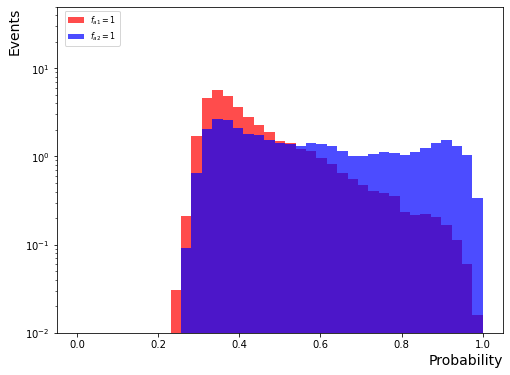

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
labels = label_names
bin_counts1, bin_edges1, patches1 = plt.hist(1-df_histb[0], bins, density=True, alpha=0.7, color='r', label=labels[0], log=True)
#bin_centres1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
#y_err1 = 1/(np.sqrt(counts_err1))
#print(y_err1[counts_err1>0])
#plt.errorbar(x = bin_centres1, y = bin_counts1, yerr = y_err1, fmt='o', capsize=0.5, color='r', ecolor='k')

bin_counts2, bin_edges2, patches2 = plt.hist(df_hists[1], bins, density=True, alpha=0.7, color='b', label=labels[1], log=True)

plt.ylim(0.01, 50)
plt.xlabel("Probability", fontsize=14, loc='right') 
plt.ylabel("Events", fontsize=14, loc='top') 
plt.legend(bbox_to_anchor=(0.15, 1), prop={'size': 8})
plt.savefig('Plots/%s_2.pdf' %Prob_hist_title, bbox_inches='tight')


Plot ROC Curve

In [91]:
# Train ROC
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train.values, y_pred_prob_train.values[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
rfpr_train = np.asarray([ ( 1. - i ) for i in fpr_train ])

# Test ROC
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test.values, y_pred_prob_test.values[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
rfpr_test = np.asarray([(1. - i) for i in fpr_test])

# Valid ROC
fpr_valid, tpr_valid, threshold_valid = metrics.roc_curve(y_valid.values, y_pred_prob_valid.values[:, 1], pos_label=1)
roc_auc_valid = metrics.auc(fpr_valid, tpr_valid)
rfpr_valid = np.asarray([(1. - i) for i in fpr_valid])

# # STXS ROC
# fpr_stxs, tpr_stxs, threshold_stxs = metrics.roc_curve(mva_test['sig/bkg'].values, mva_test['stxs_mvascore'].values, pos_label=1)
# roc_auc_stxs = metrics.auc(fpr_stxs, tpr_stxs)
# rfpr_stxs = np.asarray([(1. - i) for i in fpr_stxs])

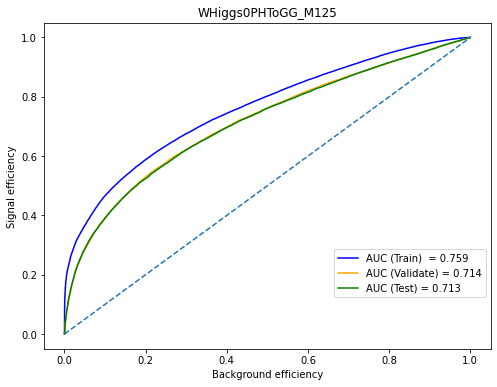

In [92]:
plt.figure(figsize=(8,6))
plt.title(Prob_hist_title)
plt.plot(fpr_train, tpr_train,  'b', label = 'AUC (Train)  = %0.3f' % roc_auc_train)
plt.plot(fpr_valid, tpr_valid, 'orange', label = 'AUC (Validate) = %0.3f' % roc_auc_valid)
plt.plot(fpr_test, tpr_test, 'g', label = 'AUC (Test) = %0.3f' % roc_auc_test) 
# plt.plot(fpr_stxs, tpr_stxs, 'r', label = 'AUC (STXS) = %0.3f' % roc_auc_stxs)
plt.legend(bbox_to_anchor=(1, 0.32))
plt.plot([0, 1], [0, 1], '--')
plt.ylabel('Signal efficiency', fontsize=10)
plt.xlabel('Background efficiency', fontsize=10)
plt.savefig('Plots/ROCCurve_%s.pdf' % Prob_hist_title, bbox_inches='tight')
